# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

Study on simple random sinusoidal images vs. real valued bent functions (maximaly non-linear) images

### Simple sinusoidal images:
Generate sinusoidal data with random phase and frequency:

$$Z = \sin(2\pi f_x x + \phi_x) \cos(2\pi f_y y + \phi_y)$$

Where:
- $f_x$ is the frequency multiplier for x
- $f_y$ is the frequency multiplier for y
- $\phi_x$ is the phase shift for x
- $\phi_y$ is the phase shift for y

### Real valued Bent functions:

$$Z = \cos(2\pi(aX + bY)) + \cos(2\pi(cX - dY))$$

Where $a$, $b$, $c$, and $d$ are parameters controlling the function's behavior.



## Imports and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
import numpy as np
import torch
import torchinfo

In [3]:
import polcanet.reports as report
import polcanet.utils as ut
from polcanet import PolcaNet

In [4]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

exp = ut.ExperimentInfoHandler(
    name="SYNTH_dataset",
    description="POLCA-Net on Synthetic Sinudosial and Bent Images",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving Images: True, saving in path: /data1/deploy/polcanet/examples/notebooks/experiments/SYNTH_dataset


## Generate Synthetic Sinudosial and Bent Images

7.748604e-07 0.9999964
0.0 1.0


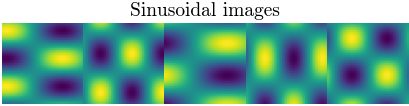

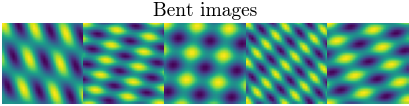

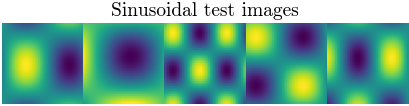

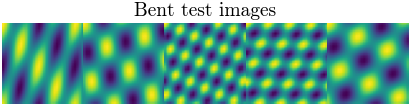

In [5]:
# Parameters
N = 32  # rows
M = 32  # cols
num_samples = 1000

# Generate 2D sinusoidal data
data_sin = ut.generate_2d_sinusoidal_data(N, M, num_samples=num_samples)
data_sin_test = ut.generate_2d_sinusoidal_data(N, M, num_samples=num_samples)

# Generate 2D real bent function images data
data_bent = ut.generate_bent_images(N, M, num_samples=3000)
data_bent_test = ut.generate_bent_images(N, M, num_samples=num_samples)
print(data_sin.min(), data_sin.max())
print(data_bent.min(), data_bent.max())
ut.set_fig_prefix("sin_train")
ut.plot_train_images(data_sin, "Sinusoidal images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_train")
ut.plot_train_images(data_bent, "Bent images", cmap="viridis", n=5)

ut.set_fig_prefix("sin_test")
ut.plot_train_images(data_sin_test, "Sinusoidal test images", cmap="viridis", n=5)
ut.set_fig_prefix("bent_test")
ut.plot_train_images(data_bent_test, "Bent test images", cmap="viridis", n=5)

### Perform PCA on datasets

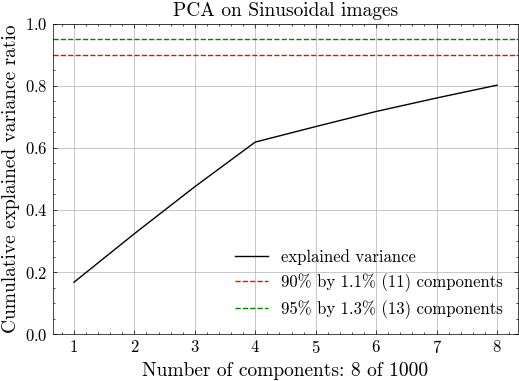

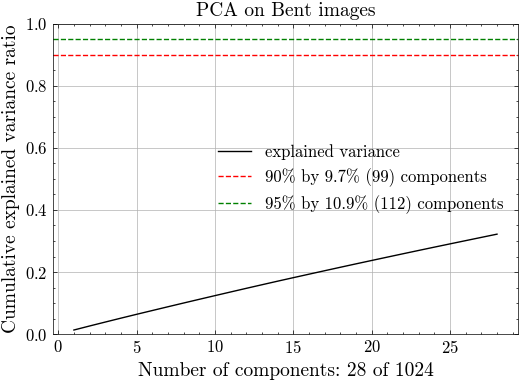

In [6]:
n_components = 8  # int((N*M)//100)
ut.set_fig_prefix("sin")
pca_sin = ut.perform_pca(data_sin, title="PCA on Sinusoidal images", n_components=n_components)
Xpca_sin = pca_sin.transform(np.squeeze(data_sin.reshape(data_sin.shape[0], -1)))
plt.show()

n_components = 28
ut.set_fig_prefix("bent")
pca_bent = ut.perform_pca(data_bent, title="PCA on Bent images", n_components=n_components)
Xpca_bent = pca_bent.transform(np.squeeze(data_bent.reshape(data_bent.shape[0], -1)))
plt.show()

## POLCA-Net

### Train on Sinusoidal Images

In [13]:
from polcanet.aencoders import ConvEncoder, LinearDecoder

ae_input = data_sin
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_sin.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder_sin = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_sin = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=4,
    act_fn=act_fn,
    bias=False,
    # output_act_fn = torch.nn.Sigmoid,
)

model_sin = PolcaNet(
    encoder=encoder_sin,
    decoder=decoder_sin,
    latent_dim=latent_dim,
    alpha=1e-2,  # ortgogonality loss
    beta=1e-2,  # variance sorting loss
    gamma=0,  # variance reduction loss
)
print(model_sin)
summary = torchinfo.summary(
    model_sin,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model_sin), "model_sin.txt")
ut.save_text(str(summary), "model_sin_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (2): SiLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): SiLU()
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): SiLU()
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): SiLU()
        (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): SiLU()
        (11): Flatten(start_dim=1, end_dim=-1)
        (12): Linear(in_features=1024, out_features=32, bias=True)
        (13): SiLU()
        (14): Linear(in_features=32, out_features=8, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1)

In [14]:
model_sin.to("cuda")
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.000277
Reconstruction Loss: 0.000205
Orthogonality Loss: 0.001317
Center of Mass Loss: 0.005887


In [15]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 6.08e-05
Reconstruction Loss: 2.879e-05
Orthogonality Loss: 0.001152
Center of Mass Loss: 0.002049


In [16]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 4.895e-05
Reconstruction Loss: 2.136e-05
Orthogonality Loss: 0.0009452
Center of Mass Loss: 0.001814


In [18]:
ut.set_fig_prefix("sin_train")
model_sin.polca_loss.loss_analyzer.print_report()

Loss Interaction Analysis Report:
Total interactions: 4425
Total conflicts: 1086
Overall conflict rate: 0.2454

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,rec,com,1475,482,0.3268,-0.0104,Weakly Conflicting
1,ort,com,1475,281,0.1905,0.0394,Weakly Cooperative
2,rec,ort,1475,323,0.2190,0.1184,Strongly Cooperative


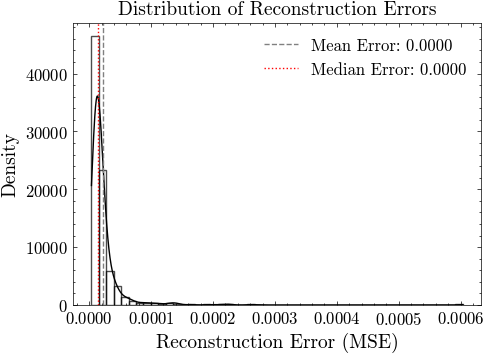

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0006


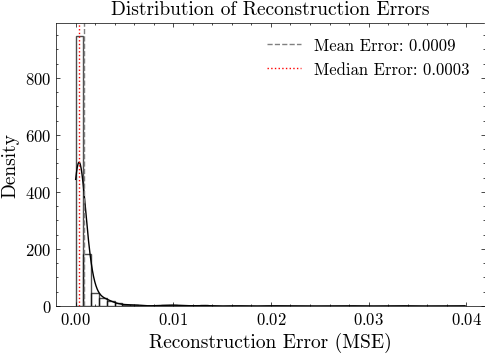

Mean Reconstruction Error: 0.0009
Median Reconstruction Error: 0.0003
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0399


In [19]:
ut.set_fig_prefix("sin_train")
report.analyze_reconstruction_error(model_sin, data_sin, n_samples=1000)
ut.set_fig_prefix("sin_test")
report.analyze_reconstruction_error(model_sin, data_sin_test, n_samples=1000)

In [20]:
latents, reconstructed = model_sin.predict(data_sin)
data_sin.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 8))

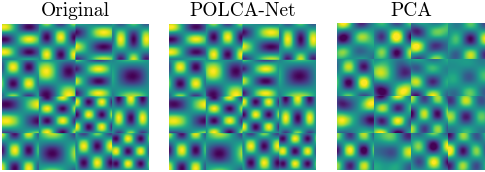

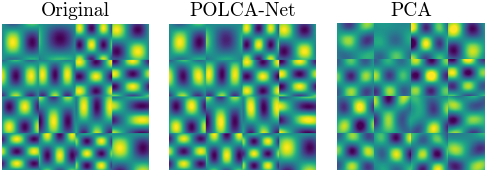

In [38]:
ut.set_fig_prefix("sin_train")
images = data_sin[0:16]
ut.plot_reconstruction_comparison(model_sin, pca_sin, images, cmap="viridis", nrow=4,n_components=8,mask=[1,1,1,1,1,1,1,1])
ut.set_fig_prefix("sin_test")
images = data_sin_test[0:16]
ut.plot_reconstruction_comparison(model_sin, pca_sin, images, cmap="viridis", nrow=4,n_components=8,mask=[1,1,1,1,1,1,1,1])

,Metric,Value
0,Mean cosine similarity,0.003072
1,Median cosine similarity,0.002505
2,Standard deviation of cosine similarity,0.002135
3,Max cosine similarity,0.009653
4,Min cosine similarity,0.000080


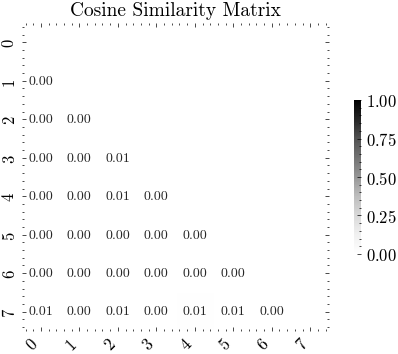

,Metric,Value
0,Mean mutual information,0.041735
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.088116
3,Max mutual information,0.576213
4,Min mutual information,0.000000


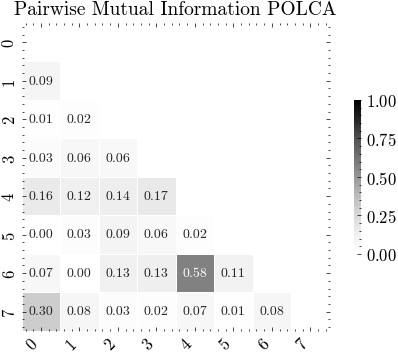

,Metric,Value
0,Mean mutual information,0.034647
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.050512
3,Max mutual information,0.188622
4,Min mutual information,0.000000


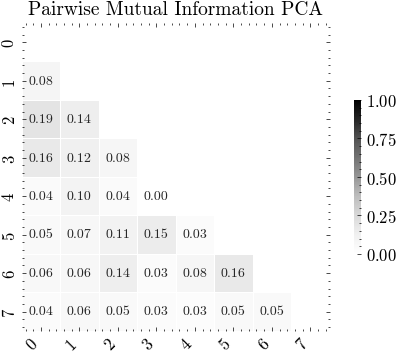

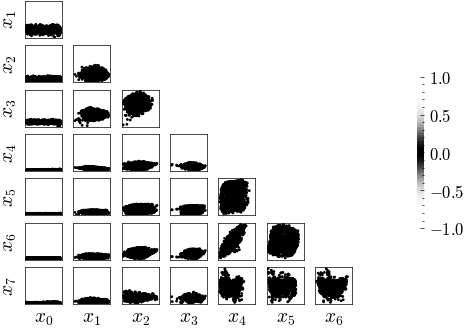

,Metric,Value
0,Mean cosine similarity,0.033847
1,Median cosine similarity,0.027245
2,Standard deviation of cosine similarity,0.023094
3,Max cosine similarity,0.087671
4,Min cosine similarity,0.001433


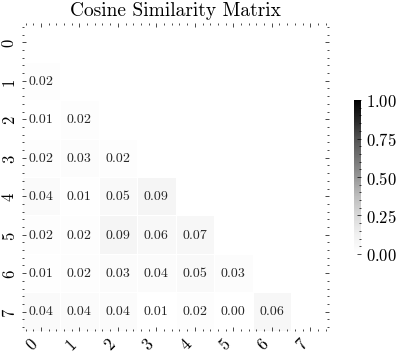

,Metric,Value
0,Mean mutual information,0.046021
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.090125
3,Max mutual information,0.582751
4,Min mutual information,0.000000


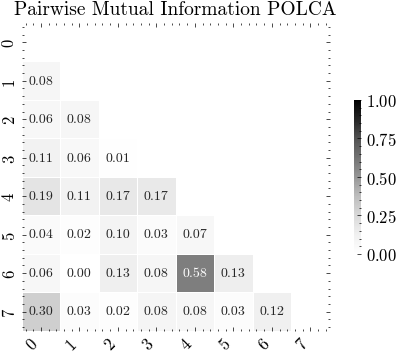

,Metric,Value
0,Mean mutual information,0.035155
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.044746
3,Max mutual information,0.133399
4,Min mutual information,0.000000


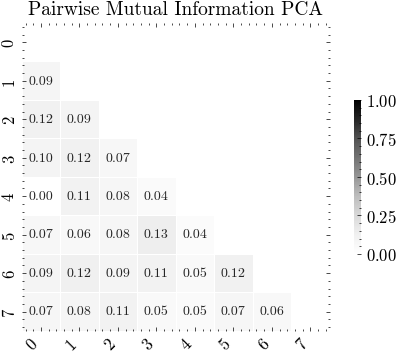

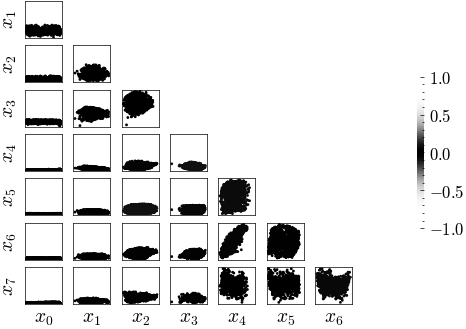

In [39]:
ut.set_fig_prefix("sin_train")
report.orthogonality_test_analysis(model_sin,pca_sin, data_sin)
ut.set_fig_prefix("sin_test")
report.orthogonality_test_analysis(model_sin,pca_sin, data_sin_test)

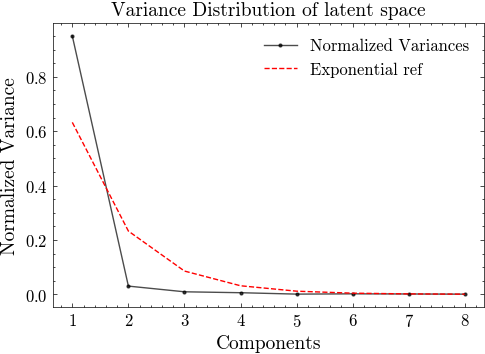

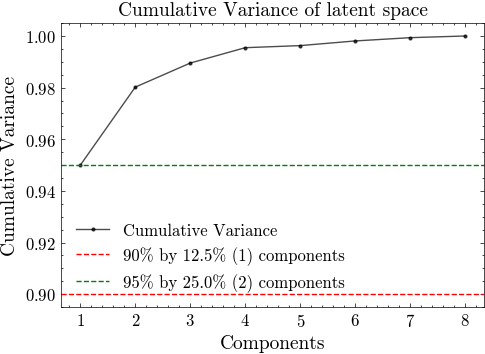

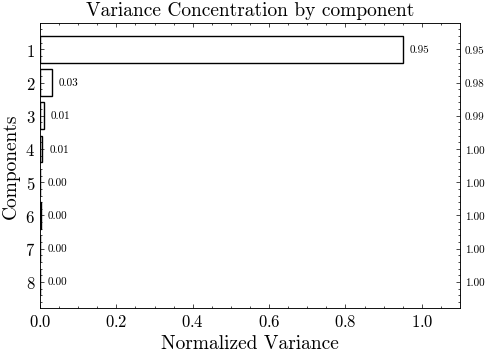

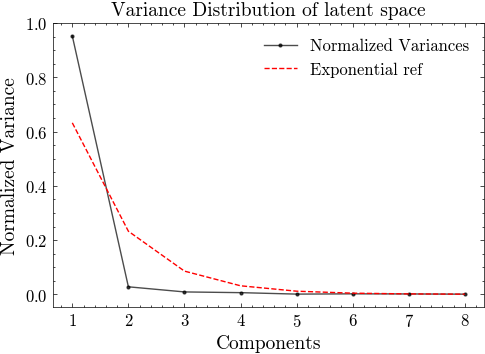

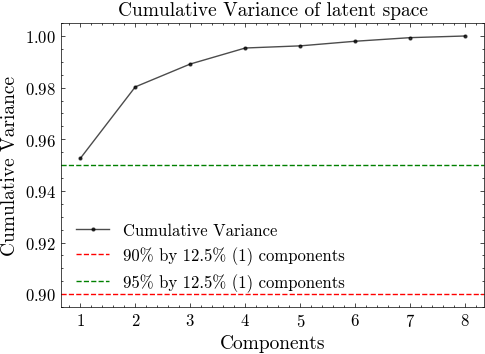

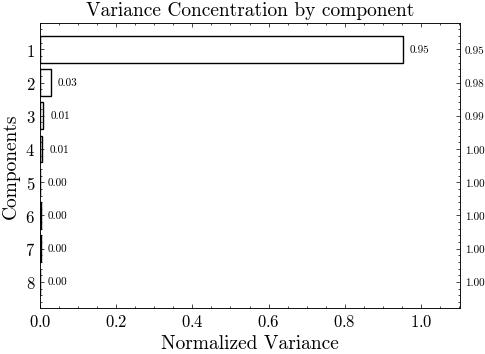

In [40]:
ut.set_fig_prefix("sin_train")
report.variance_test_analysis(model_sin, data_sin)
ut.set_fig_prefix("sin_test")
report.variance_test_analysis(model_sin, data_sin_test)

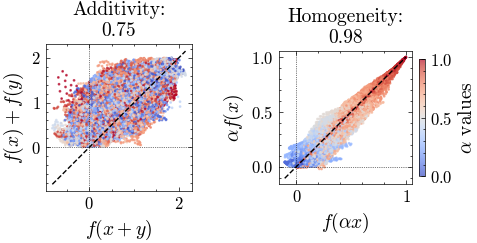

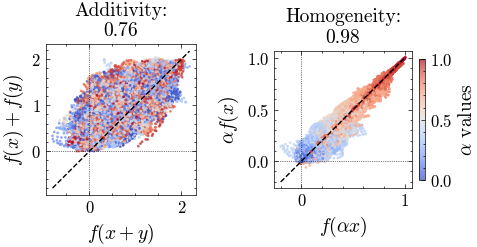

In [41]:
ut.set_fig_prefix("sin_train")
report.linearity_tests_analysis(model_sin, data_sin, alpha_min=0, num_samples=200)
ut.set_fig_prefix("sin_test")
report.linearity_tests_analysis(model_sin, data_sin_test, alpha_min=0, num_samples=200)

In [42]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = ut.plot2d_analysis(Xpca_sin, np.zeros(Xpca_sin.shape[0]), title="PCA transform", legend=False)
with o2:
    _, _ = ut.plot2d_analysis(latents, np.zeros(Xpca_sin.shape[0]), title="POLCA-Net latent",  legend=False)
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

### Train on Bent Images

In [43]:
from polcanet.aencoders import ConvEncoder, LinearDecoder
ae_input = data_bent
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca_bent.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_bent = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_bent = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=5 * 256,
    num_layers=4,
    act_fn=act_fn,
    bias=False,
)

model_bent = PolcaNet(
    encoder=encoder_bent,
    decoder=decoder_bent,
    latent_dim=latent_dim,
    alpha=1e-2,  # ortgogonality loss
    beta=1e-2,  # variance sorting loss
    gamma=0,  # variance reduction loss
)
print(model_bent)
summary = torchinfo.summary(
    model_bent,
    (1, *input_dim),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model_bent), "model_bent.txt")
ut.save_text(str(summary), "model_bent_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): ConvEncoder(
      (encoder): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (2): SiLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): SiLU()
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): SiLU()
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (8): SiLU()
        (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): SiLU()
        (11): Flatten(start_dim=1, end_dim=-1)
        (12): Linear(in_features=1024, out_features=112, bias=True)
        (13): SiLU()
        (14): Linear(in_features=112, out_features=28, bias=True)
      )
    )
    (post_encoder): Sequential(
      (0): Linear(in_features=28, out_features=28, bias=True)
    

In [44]:
model_bent.to("cuda")
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.0001553
Reconstruction Loss: 0.0001174
Orthogonality Loss: 0.0018
Center of Mass Loss: 0.001994


In [45]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 2.903e-05
Reconstruction Loss: 3.055e-06
Orthogonality Loss: 0.001666
Center of Mass Loss: 0.0009312


In [46]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 2.535e-05
Reconstruction Loss: 1.458e-06
Orthogonality Loss: 0.001617
Center of Mass Loss: 0.0007722


In [48]:
ut.set_fig_prefix("bent_train")
model_bent.polca_loss.loss_analyzer.print_report()

Loss Interaction Analysis Report:
Total interactions: 21981
Total conflicts: 744
Overall conflict rate: 0.0338

Pairwise Statistics (sorted by similarity):


,loss1,loss2,interactions,conflicts,conflict_rate,avg_similarity,relationship
0,rec,com,7327,564,0.0770,-0.0088,Weakly Conflicting
1,rec,ort,7327,177,0.0242,0.0300,Weakly Cooperative
2,ort,com,7327,3,0.0004,0.1009,Strongly Cooperative


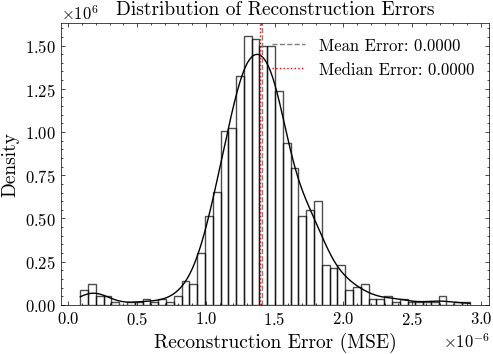

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0000


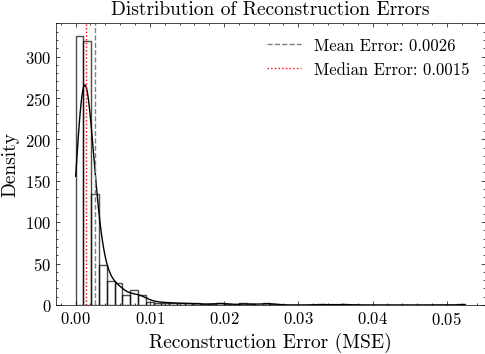

Mean Reconstruction Error: 0.0026
Median Reconstruction Error: 0.0015
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0524


In [49]:
ut.set_fig_prefix("bent_train")
report.analyze_reconstruction_error(model_bent, data_bent, n_samples=1000)
ut.set_fig_prefix("bent_test")
report.analyze_reconstruction_error(model_bent, data_bent_test, n_samples=1000)

In [50]:
latents, reconstructed = model_bent.predict(data_bent)
data_bent.shape, reconstructed.shape, latents.shape

((3000, 32, 32), (3000, 32, 32), (3000, 28))

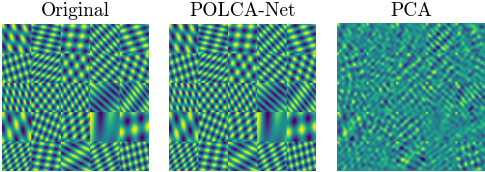

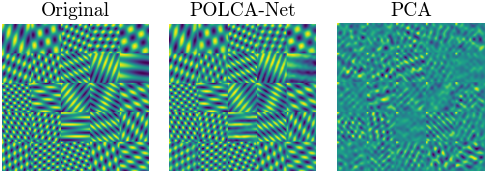

In [51]:
ut.set_fig_prefix("sin_train")
images = data_bent[0:25]
ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=5)
ut.set_fig_prefix("sin_test")
images = data_bent_test[0:25]
ut.plot_reconstruction_comparison(model_bent, pca_bent, images, cmap="viridis", nrow=5)

,Metric,Value
0,Mean cosine similarity,0.019276
1,Median cosine similarity,0.017368
2,Standard deviation of cosine similarity,0.014555
3,Max cosine similarity,0.073093
4,Min cosine similarity,0.000035


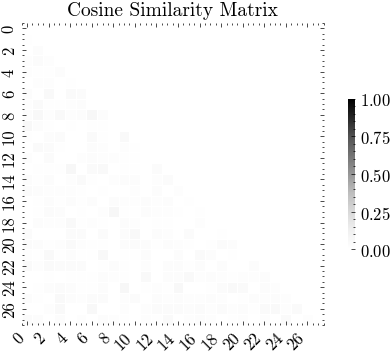

,Metric,Value
0,Mean mutual information,0.013046
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.041193
3,Max mutual information,0.916154
4,Min mutual information,0.000000


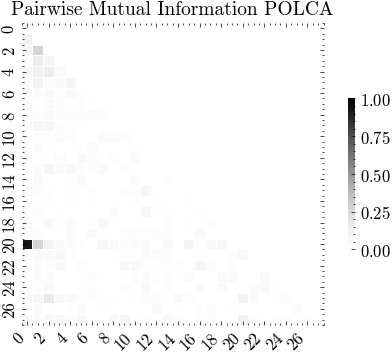

,Metric,Value
0,Mean mutual information,0.008629
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.018043
3,Max mutual information,0.176818
4,Min mutual information,0.000000


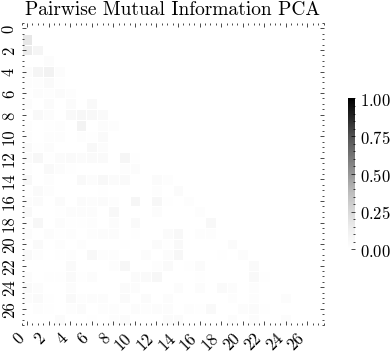

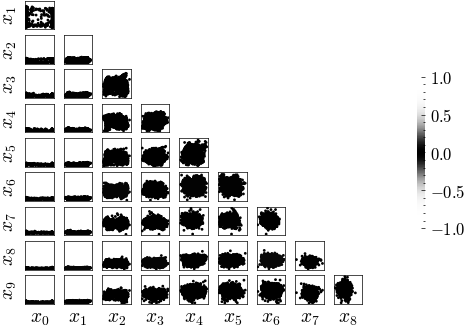

,Metric,Value
0,Mean cosine similarity,0.027530
1,Median cosine similarity,0.022835
2,Standard deviation of cosine similarity,0.021184
3,Max cosine similarity,0.105874
4,Min cosine similarity,0.000027


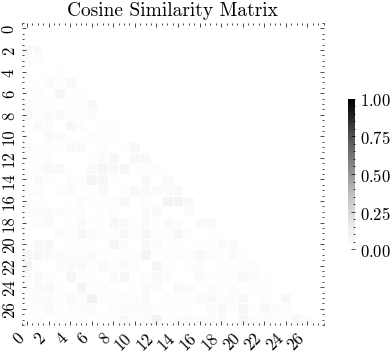

,Metric,Value
0,Mean mutual information,0.011663
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.038743
3,Max mutual information,0.941012
4,Min mutual information,0.000000


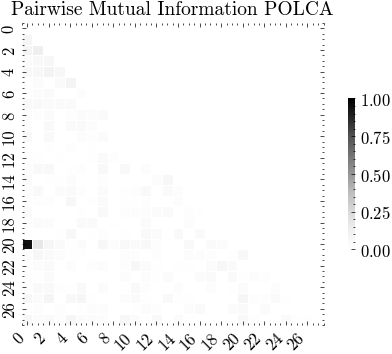

,Metric,Value
0,Mean mutual information,0.008113
1,Median mutual information,0.000000
2,Standard deviation of mutual information,0.017028
3,Max mutual information,0.196204
4,Min mutual information,0.000000


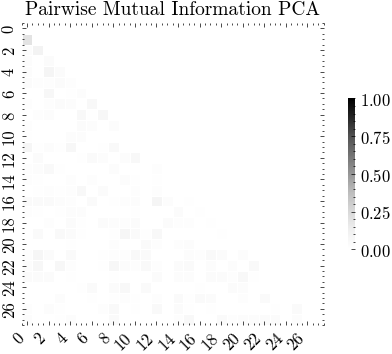

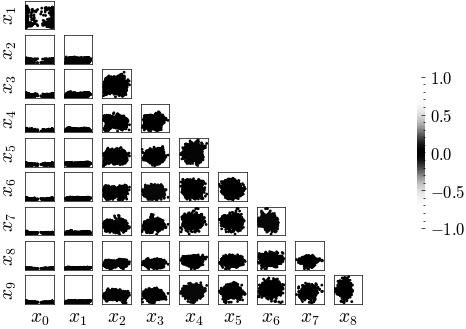

In [52]:
ut.set_fig_prefix("bent_train")
report.orthogonality_test_analysis(model_bent,pca_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.orthogonality_test_analysis(model_bent,pca_bent, data_bent_test)

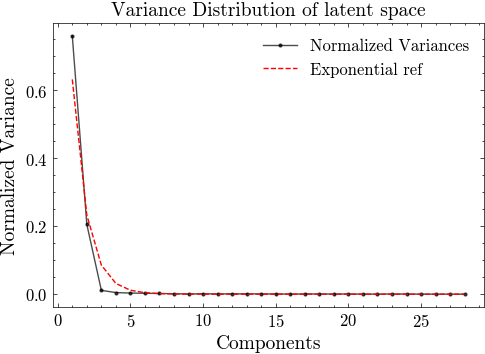

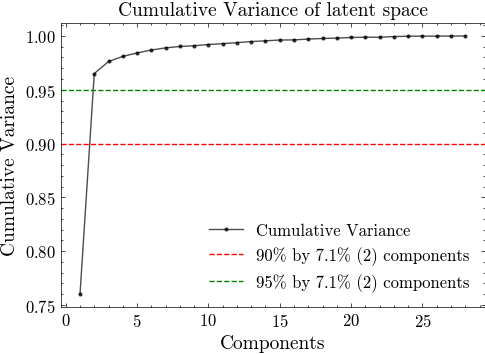

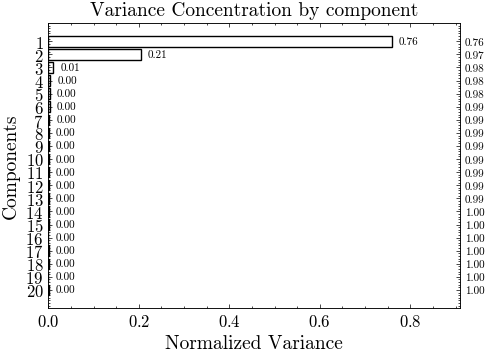

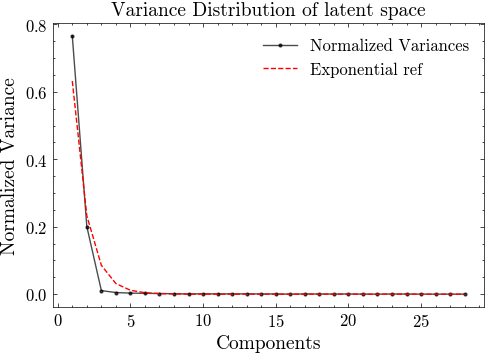

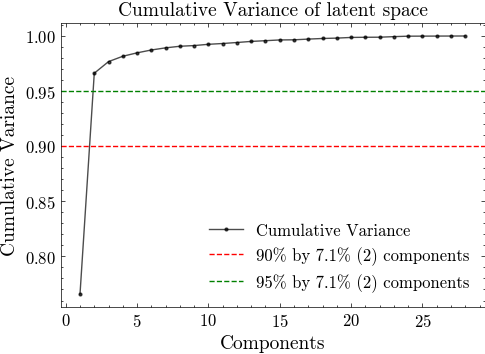

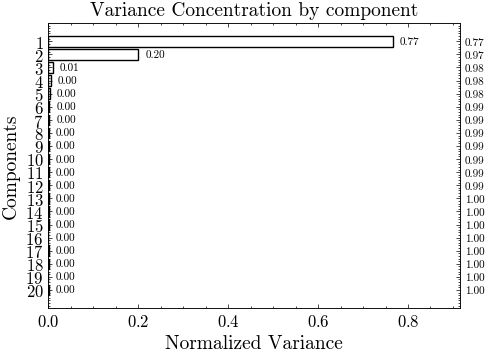

In [53]:
ut.set_fig_prefix("bent_train")
report.variance_test_analysis(model_bent, data_bent)
ut.set_fig_prefix("bent_test")
report.variance_test_analysis(model_bent, data_bent_test)

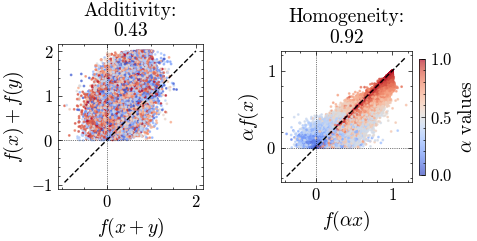

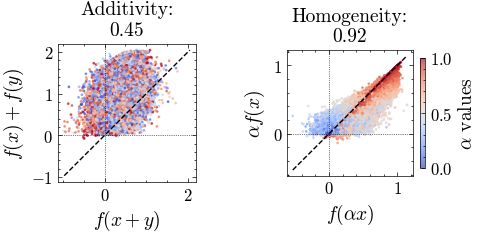

In [54]:
ut.set_fig_prefix("bent_train")
report.linearity_tests_analysis(model_bent, data_bent, alpha_min=0, num_samples=200)
ut.set_fig_prefix("bent_test")
report.linearity_tests_analysis(model_bent, data_bent_test, alpha_min=0, num_samples=200)

## Test Overall

In [55]:
experiment_data = {
    "Sinudoidal": (
        data_sin,
        model_sin,
        pca_sin,
    ),
    "Bent": (
        data_bent,
        model_bent,
        pca_bent,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,NMSE,PSNR,SSI
Method,,,
POLCA Sinudoidal,0.0076,47.9795,0.9997
PCA Sinudoidal,0.1820,20.8163,0.8427
POLCA Bent,0.0021,58.6673,1.0000
PCA Bent,0.3656,13.8473,0.4928
